In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
fraud_mock_df = pd.read_csv("../data/fraud_mock.csv")

In [17]:
fraud_transactions = fraud_mock_df[fraud_mock_df['is_fraud'] == 1]

# Overview

ดูภาพรวมของข้อมูลทั้งหมด

In [18]:
fraud_mock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [19]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
fraud_mock_df.describe()

,time_ind,amount,src_bal,src_new_bal,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [20]:
fraud_mock_df['transac_type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [21]:
print(fraud_mock_df['is_fraud'].value_counts())

is_fraud
0    6354407
1       8213
Name: count, dtype: int64


In [22]:
null_counts = fraud_mock_df.isnull().sum()

print("Missing Values")
print(null_counts)

Missing Values
time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64


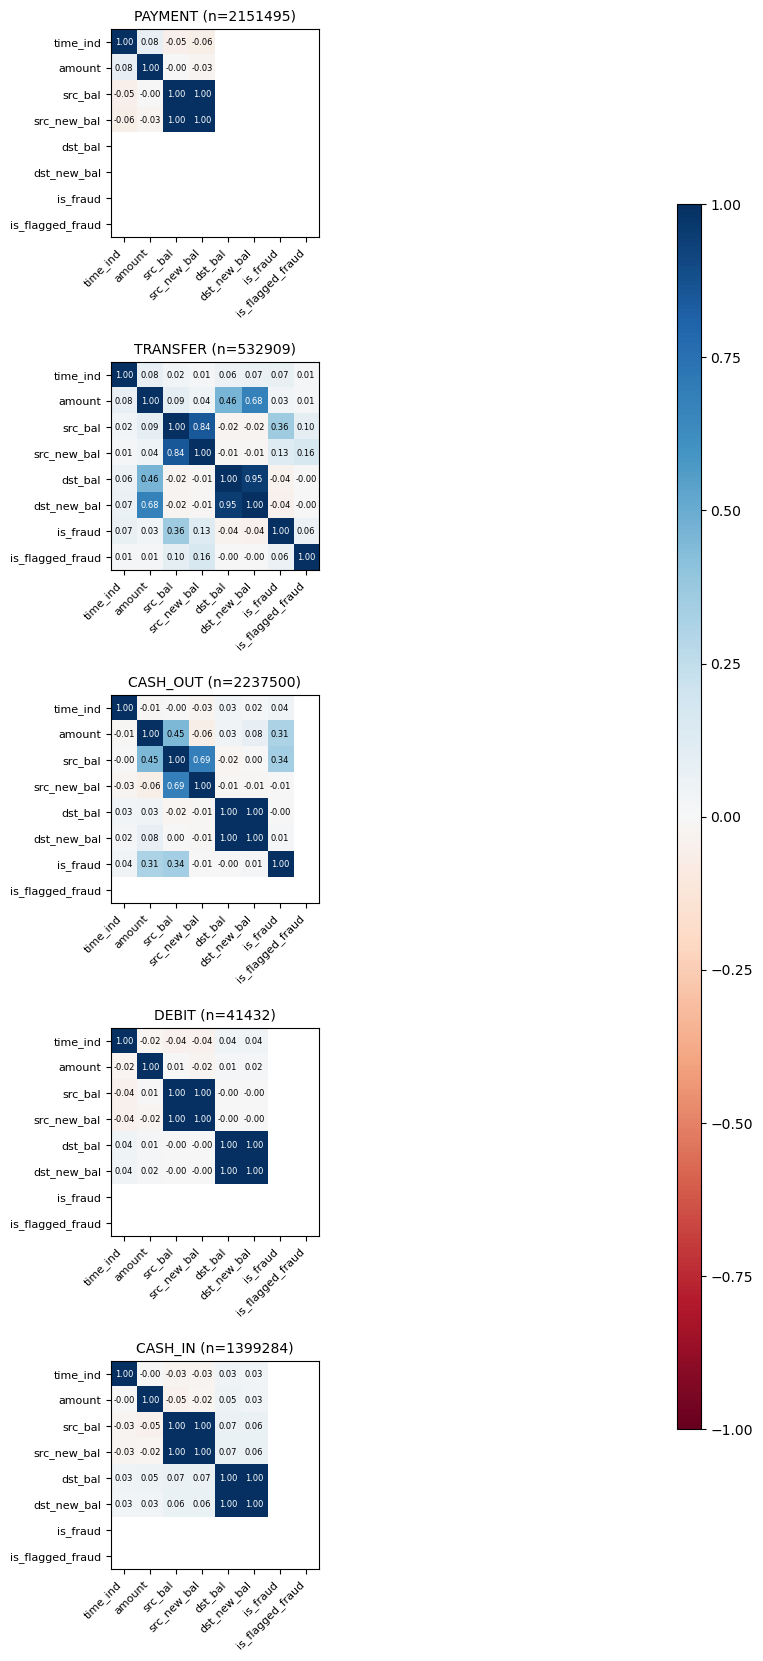

In [23]:
# ปรับ layout ให้ label ไม่ทับกัน
types = fraud_mock_df['transac_type'].unique()
numeric_cols = fraud_mock_df.select_dtypes(include=[np.number]).columns.tolist()
n = len(types)

fig_corr, axes = plt.subplots(n, 1, figsize=(12, 3.5 * n))
if n == 1:
    axes = [axes]

ims = []
for ax_, t in zip(axes, types):
    df_t = fraud_mock_df[fraud_mock_df['transac_type'] == t]
    corr = df_t[numeric_cols].corr()
    im = ax_.imshow(corr, cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest', aspect='equal')
    ims.append(im)

    ax_.set_xticks(range(len(numeric_cols))); ax_.set_yticks(range(len(numeric_cols)))
    ax_.set_xticklabels(numeric_cols, rotation=45, ha='right', fontsize=8)
    ax_.set_yticklabels(numeric_cols, fontsize=8)
    ax_.set_title(f"{t} (n={len(df_t)})", fontsize=10)
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            val = corr.iat[i, j]
            if pd.isna(val):
                continue
            txt = f"{val:.2f}"
            ax_.text(j, i, txt, ha='center', va='center',
                     color='white' if abs(val) > 0.5 else 'black',
                     fontsize=6)

fig_corr.subplots_adjust(right=0.87, left=0.12, top=0.95, bottom=0.07, hspace=0.6) # <--- ขยับไปขวา
cax = fig_corr.add_axes([0.88, 0.15, 0.02, 0.7]) 
fig_corr.colorbar(ims[-1], cax=cax)
plt.show()

# Features time_ind

## Relation is_fraud & time between the days

จากกราฟด้านล่าง Plot ความสัมพันธ์ของช่วงเวลา กับ จำนวนครั้งของการโกง เพื่อดูว่าช่วงเวลาในแต่ละวันมีผลต่อความถี่ของการโกงหรือไม่

: ซึ่งจากกราฟจะวิเคราะห์ได้ว่า การโกงจะมีความถี่สูงขึ้นในช่วงเวลาชั่วโมงที่ 2-7 ของวัน 

จึงคิดว่าควรสร้าง Features hour_of_day ในการเทรน

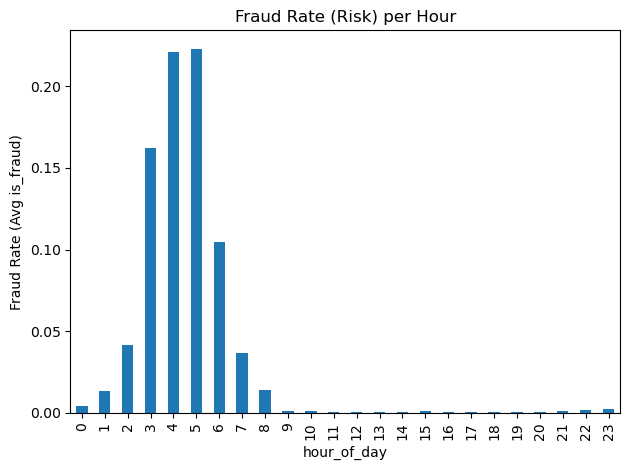

In [24]:
fraud_mock_df['hour_of_day'] = fraud_mock_df['time_ind']%24

fraud_rate_per_day = fraud_mock_df.groupby('hour_of_day')['is_fraud'].mean()
fraud_rate_per_day.plot(kind='bar')

plt.xlabel('hour_of_day')
plt.ylabel('Fraud Rate (Avg is_fraud)') 
plt.title('Fraud Rate (Risk) per Hour') 
plt.tight_layout()
plt.show()

## Relation is_fraud & days

จากกราฟด้านล่าง Plot ความสัมพันธ์ของวัน กับ จำนวนครั้งของการโกง เพื่อดูว่าวันมีผลต่อความถี่ของการโกงหรือไม่??

: ซึ่งจากกราฟจะวิเคราะห์ได้ว่า มีวันที่โดดมาอยู่วันเดียวคือวันที่ 30 ซึ่งมีfraud_rateถึง 1.0

จึงคิดว่าควรสร้าง Features Day ในการเทรน

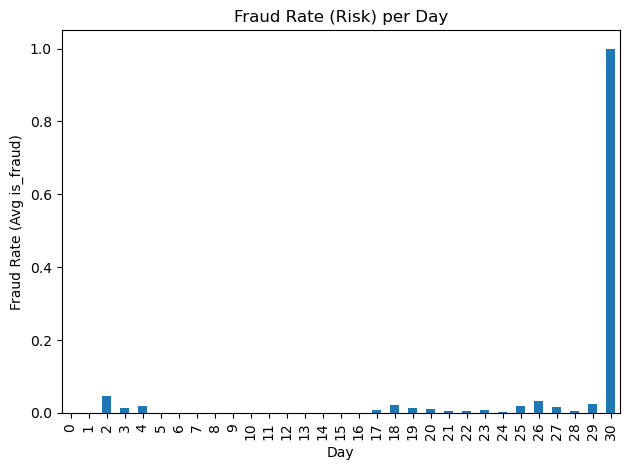

In [25]:
fraud_mock_df['day'] = fraud_mock_df['time_ind']//24

fraud_rate_per_day = fraud_mock_df.groupby('day')['is_fraud'].mean()
fraud_rate_per_day.plot(kind='bar')

plt.xlabel('Day')
plt.ylabel('Fraud Rate (Avg is_fraud)') 
plt.title('Fraud Rate (Risk) per Day') 
plt.tight_layout()
plt.show()

# Features transac_type

### Relation between is_fraud & type of transac_type

เพื่อวิเคราะห์ว่า Transac_type มีผลต่อการโกงหรือไม่?

: โดยเราเลือก plot เป็น bar chart เพื่อให้เห็นความแตกต่างระหว่าง transac_type ได้ว่า transac_type มีผลต่อการโกงซึ่งการโกงจะเกิดใน tranc_type เพียงสองประเภทนั้นก็คือ 'CASH_OUT' and 'TRANSFER'

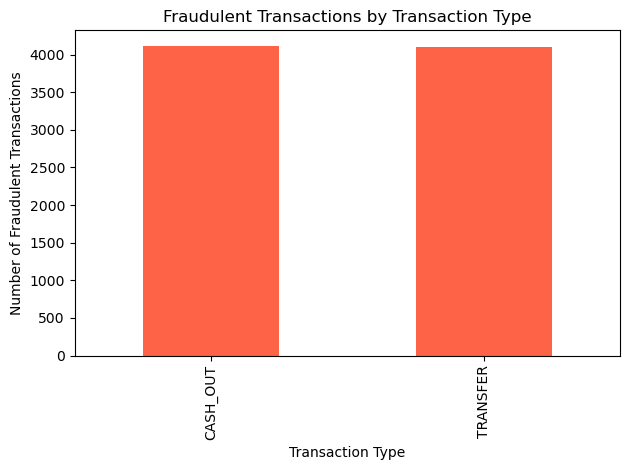

In [26]:
fraud_type_counts = fraud_transactions['transac_type'].value_counts()

fraud_type_counts.plot(kind='bar', color='tomato')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Transaction Type')
plt.tight_layout()
plt.show()

# Features is_fragged_fraud

## Relation between is_fraud & is_flagged_fraud

เพื่อวิเคราะห์ว่า is_fragged_fraud มีการ flagged ได้ถูกต้อง มากน้อยแค่ไหน

: เลือกใช้เป็น Heat Map เพื่อให้เห็นความต่างของค่าแต่ละช่องผ่านความเข้มของสี ซึ่งได้ผลลัพธ์ว่าถ้า is_flagged_fraud==1 จะได้ว่า Account นั้นเป็น fraud แน่นอน แต่ว่าตอนนี้ is_flagged_fraud ตรวจจับได้เพียง 16 คนจากทั้งหมด 8213 คน ( ML เราควรเพิ่ม Recall ให้ตรวจจับโจรได้มากขึ้น ) 

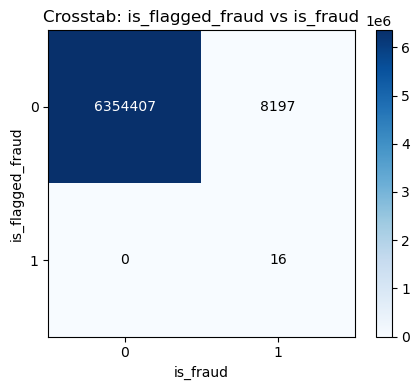

In [27]:
ct = pd.crosstab(fraud_mock_df['is_flagged_fraud'], fraud_mock_df['is_fraud'],
                 rownames=['is_flagged_fraud'], colnames=['is_fraud'])

# heatmap ด้วย matplotlib (ไม่ต้อง import เพิ่ม)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(ct.values, cmap='Blues')
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        ax.text(j, i, ct.iat[i, j], ha='center', va='center',
                color='white' if ct.iat[i, j] > ct.values.max()/2 else 'black')
ax.set_xticks(range(ct.shape[1])); ax.set_yticks(range(ct.shape[0]))
ax.set_xticklabels(ct.columns); ax.set_yticklabels(ct.index)
ax.set_xlabel('is_fraud'); ax.set_ylabel('is_flagged_fraud')
ax.set_title('Crosstab: is_flagged_fraud vs is_fraud')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Features src_acc & dst_acc Analysis

ดูความสำคัญของ Features src_acc & dst_acc ว่าผู้ี่ใช้บัญชีมีการโกงซ้ำๆไหม

: ได้ผลว่าแต่ละบัญชีมีการโกงเฉลี่ยบัญชีละ 1 ครั้ง => คนที่โกงใช้บัญชีใหม่ในการโกงเสมอ ซึ่งจะแบ่งออกเป็นสองแนวทางคือ
1. มองว่าบัญชีไม่มีผลต่อการตัดสินใจในอนาคต + ป้องกัน Data Leaked = ตัด Features src_acc & dst_acc ทิ้งเลย 

**( เลือกใช้วิธีนี้เนื่องจากไม่สามารถเช็คได้ว่าในระบบจริง acc นั้นๆทำ transaction เป็นครั้งแรก จริงหรือไม่ )**

2. มองว่าคนที่โกงจะใช้บัญชีใหม่เสมอ = ทำ Feature ใหม่เป็น is_new_src_acc & is_new_dst_acc

In [28]:
print(f"fraud_times: {len(fraud_transactions)} ครั้ง\n")

# fraud_src_acc
fraud_counts_by_sender = fraud_transactions.groupby('src_acc').size()
avg_fraud_count_per_sender = fraud_counts_by_sender.mean()

print(f"src_acc (Sender)")
print(f"number of fraud_src_acc: {len(fraud_counts_by_sender)} บัญชี")
print(f"เฉลี่ยแล้ว src_acc โกงบัญชีละ: {avg_fraud_count_per_sender:.2f} ครั้ง")


# fraud_dst_acc
fraud_counts_by_receiver = fraud_transactions.groupby('dst_acc').size()
avg_fraud_count_per_receiver = fraud_counts_by_receiver.mean()

print(f"\ndst_acc (Reciever)")
print(f"number of fraud_dst_acc: {len(fraud_counts_by_receiver)} บัญชี")
print(f"เฉลี่ยแล้ว dst_acc โกงบัญชีละ: {avg_fraud_count_per_receiver:.2f} ครั้ง")

fraud_times: 8213 ครั้ง

src_acc (Sender)
number of fraud_src_acc: 8213 บัญชี
เฉลี่ยแล้ว src_acc โกงบัญชีละ: 1.00 ครั้ง

dst_acc (Reciever)
number of fraud_dst_acc: 8169 บัญชี
เฉลี่ยแล้ว dst_acc โกงบัญชีละ: 1.01 ครั้ง
